In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.float_format', '{:.2f}'.format)
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import rand_score

In [206]:
table = pd.read_excel('lr1.xlsx')
# Исходные данные 12-го варианта
table12 = pd.concat([
    table[7:11],
    table[12:25],
    table[32:37],
    table[38:46],
    table[72:78],
    table[79:],
])
X = table12.iloc[:,2:]

In [207]:
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit on the training data
scaler.fit(X)
# Transform both the training and testing data
X = scaler.transform(X)

<Axes: >

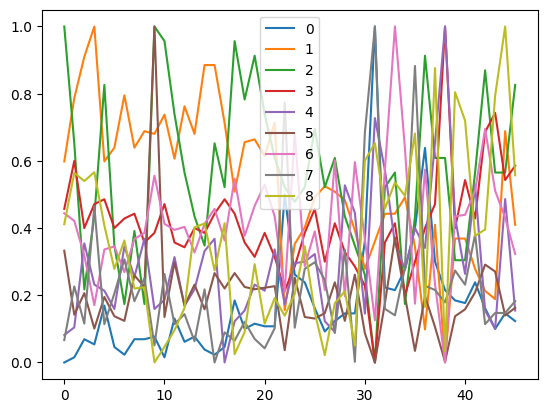

In [208]:
pd.DataFrame(X).plot()

In [209]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

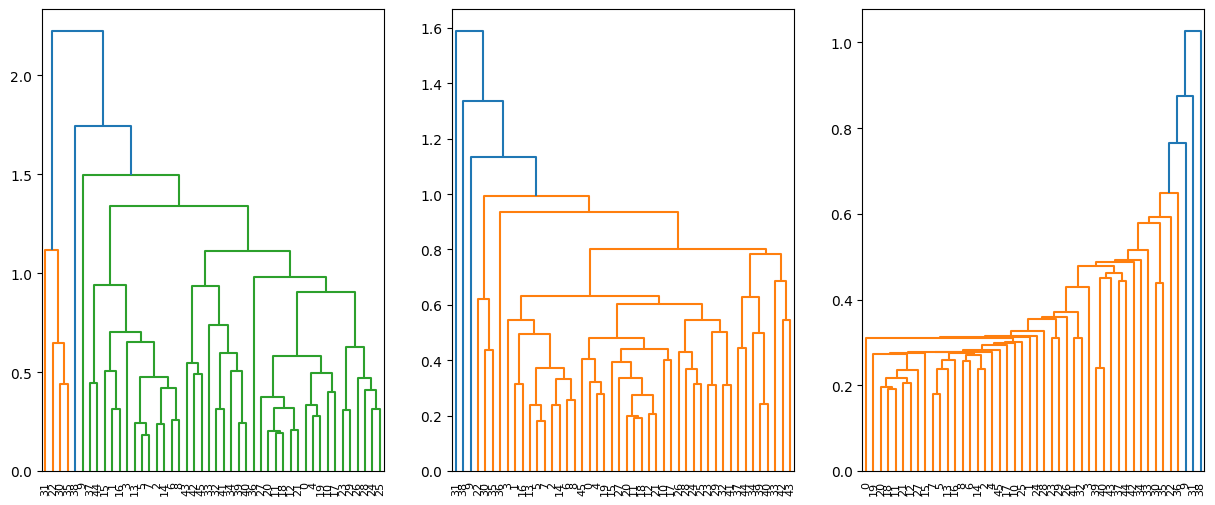

In [210]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Создаем модели
complete_clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0, linkage='complete')
average_clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0, linkage='average')
single_clustering = AgglomerativeClustering(n_clusters=None,distance_threshold=0, linkage='single')

# Подгоняем модели
complete_clustering.fit(X)
average_clustering.fit(X)
single_clustering.fit(X)

# Выводим на разные дендрограммы
plot_dendrogram(complete_clustering, ax=axs[0])
plot_dendrogram(average_clustering, ax=axs[1])
plot_dendrogram(single_clustering, ax=axs[2])

In [211]:
db_score = {}
for n_clusters in range(2, 46):
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)

    # Вычисление метрики
    new_score = davies_bouldin_score(X, kmeans.labels_)
    db_score[n_clusters] = new_score

best_score = min(db_score.values())
n_clusters = dict(zip(db_score.values(),db_score.keys()))[best_score]
print(f"Количество кластеров: {n_clusters}, Метрика Дэвиса-Болдина: {best_score:.2f}")

Количество кластеров: 45, Метрика Дэвиса-Болдина: 0.18


<Axes: >

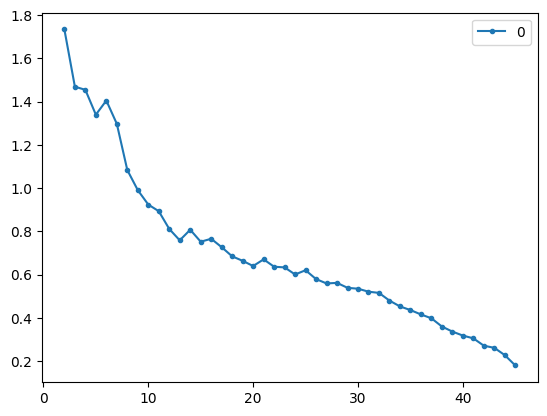

In [212]:
pd.DataFrame(db_score, index=[0]).T.plot(marker='.')

In [220]:
kmeans_l = KMeans(n_clusters=5, random_state=42).fit(X).labels_
knn_l = AgglomerativeClustering(n_clusters=2, linkage='complete').fit(X).labels_

ri = rand_score(knn_l, kmeans_l)

print(f"Индекс Рэнда равен: {ri:.2f}")

Индекс Рэнда равен: 0.35


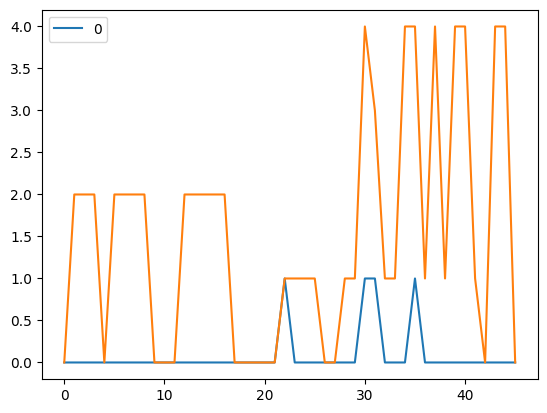

In [221]:
pd.DataFrame(knn_l).plot().plot(kmeans_l)

In [222]:
db_cluster = {0: [], 1: [], 2: [], 3: [], 4: []}
for i, arr in enumerate(X):
    db_cluster[kmeans_l[i]].append(arr)
result = {}
for k,v in db_cluster.items():
    result[k + 1] = np.mean(v, axis=0)

In [227]:
df = pd.DataFrame(result)
df.columns=['cluster1', 'cluster2', 'cluster3', 'cluster4', 'cluster5']
df.index = table12.columns[2:]
df.style.background_gradient(cmap='Greens')

,cluster1,cluster2,cluster3,cluster4,cluster5
х1,0.107692,0.271329,0.049359,1.000000,0.243269
х2,0.573770,0.321908,0.782104,0.360656,0.392418
х3,0.810559,0.561265,0.409420,0.000000,0.402174
х4,0.425510,0.414286,0.429762,0.000000,0.428571
х5,0.181169,0.441736,0.242045,0.727273,0.344886
х6,0.282765,0.172435,0.186735,0.000000,0.141342
x7,0.452274,0.456584,0.353513,0.125561,0.403587
x8,0.117043,0.261722,0.188889,1.000000,0.358114
x9,0.201966,0.242737,0.368557,0.653053,0.746481
